In [1]:
import pandas as pd
import numpy as np
import warnings; 
import matplotlib.pyplot as plt
warnings.simplefilter('ignore')
#from sklearn.preprocessing import CategoricalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint
from sklearn.ensemble import RandomForestClassifier

## Creating Test/Train Sets

In [2]:
# FLAGS TO TOGGLE BETWEEN DIFFERENT MODELS
# flag_baseline: 
#   1 - absence of any spatial or temporal features (should be with flag_early = 1)
#   0 - all features
# flag_full: 
#   1 - full asylum only (ASYL)
#   0 - any asylum (ASYL,ASYW,WCAT)
# flag_early: 
#   1 - early predictability. features a function of osc_date. 
#   0 - late predictability. features a function of last hearing.
# flag_spatialonly: baseline features + spatial features
# flag_temponly: baseline features + temporal features

# flags
flag_baseline = 0
flag_full = 0
flag_early = 0
flag_spatialonly = 1
flag_temponly = 0

# used for loading appropriate dataset file
if flag_early:
    tag_pred = 'early'
else:
    tag_pred = 'late'
    
if flag_full:
    tag_asyl = 'full'
else:
    tag_asyl = 'any'

In [3]:
# LOAD AND MERGE DATA FILES

# load
path = '/data/WorkData/spatialtemporal/'
file = pd.read_csv(path + 'finalmerge_'+ tag_asyl + '_' + tag_pred + '.csv')
timefile = pd.read_csv(path + 'gr_lastyear_' + tag_pred + '.csv')
test_cases = pd.read_csv(path + 'test_cases_last_hearing.csv', header=None)

# merge
if (not flag_baseline) and (not flag_spatialonly): file = pd.merge(file, timefile, on=['idnproceeding','idncase'], how='left')

In [8]:
file.dtypes

idncase                     float64
idnproceeding               float64
dec                         float64
numAppsPerProc                int64
nat                          object
case_type                    object
c_asy_type                   object
base_city_code               object
hearing_loc_code             object
osc_date                     object
comp_date                    object
attorney_flag               float64
tracid                      float64
hearing_city                 object
base_city                    object
numProcPerCase                int64
adj_medium                   object
adj_date                     object
sched_type                   object
lang_hearing                 object
notice_desc                  object
adj_time_start2              object
adj_time_stop2               object
durationHearing             float64
adj_rsn_desc                 object
numHearingsPerProc            int64
durationFirstLastHearing      int64
averageHearingDur           

In [4]:
# GET TRAINING DATASET

test_cases = test_cases.rename(columns={0:'num'})
train = file[~file.idncase.isin(test_cases.num)]

In [5]:
# DEFINE CLEANING SCRIPT AND FEATURE NAMES
# this file removes any irrelevant features from dataset

if flag_early: # early predictability
    cols = ['idncase', 'idnproceeding','adj_date','comp_date','osc_date','base_city_code',
            'notice_desc','adj_time_start2','adj_time_stop2','durationHearing',
            'numAppsPerProc','numProcPerCase','osc_date','adj_rsn_desc']
else: # late predictability
    #note: temporary fix by dropping duration hearing and averageHearingDur, which have NaNs. change later!
    cols = ['idncase', 'idnproceeding','adj_date','comp_date','osc_date','numAppsPerProc','numProcPerCase','base_city_code',
            'notice_desc','adj_time_start2','adj_time_stop2','adj_rsn_desc','durationHearing','averageHearingDur']

if flag_spatialonly: # spatial features only
    if flag_early: cols2 = ['osc_date_delta','pres_aff','hearingYear','hearingMonth','hearingDayOfWeek']
    else: cols2 = ['osc_date_delta','pres_aff','hearingYear','hearingMonth','hearingDayOfWeek',
                  'numHearingsPerProc','durationFirstLastHearing','caseDuration']
    
if flag_temponly: # temporal features only
    cols2 = ['hearing_loc_code','base_city','hearing_city']

if flag_baseline: # baseline model only
    cols = ['dec','tracid','nat','c_asy_type','case_type','lang_hearing',
            'attorney_flag','sched_type','adj_medium'] # dropping spatial and temporal variables
    #'numAppsPerProc','numProcPerCase','osc_date_delta'
    

class Cleaning(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        
        # drop unused columns
        if flag_baseline: X = X[cols]
        else: X = X.drop(columns=cols)
        
        if flag_spatialonly: X = X.drop(columns=cols2)
        if flag_temponly: X = X.drop(columns=cols2)
            
        return X
    

In [6]:
# RUNNING CLEANING SCRIPT

clean = Cleaning()
train_data = clean.transform(train)

In [9]:
# MAKE VARIABLES CORRECT DTYPES

train_data['tracid'] = train_data['tracid'].astype('str')
train_data['adj_medium'] = train_data['adj_medium'].astype('str')
train_data['sched_type'] = train_data['sched_type'].astype('str')
train_data['nat'] = train_data['nat'].astype('str')
train_data['case_type'] = train_data['case_type'].astype('str')
train_data['c_asy_type'] = train_data['c_asy_type'].astype('str')
train_data['lang_hearing'] = train_data['lang_hearing'].astype('str')

if (not flag_baseline): 
    if not flag_temponly:
        train_data['hearing_loc_code'] = train_data['hearing_loc_code'].astype('str')
        train_data['hearing_city'] = train_data['hearing_city'].astype('str')
        train_data['base_city'] = train_data['base_city'].astype('str')
    if not flag_spatialonly:
        train_data['hearingMonth'] = train_data['hearingMonth'].astype('str')
        train_data['hearingDayOfWeek'] = train_data['hearingDayOfWeek'].astype('str')    
        train_data['hearingYear'] = train_data['hearingYear'].astype('float64')
        train_data['pres_aff'] = train_data['pres_aff'].astype('str')
    #if not flag_early:
        #train_data['hearingMonth'] = train_data['hearingMonth'].astype('str')
    
    

In [10]:
# last minute inspection of features and dtypes to make sure they are correct
train_data.dtypes

dec                 float64
nat                  object
case_type            object
c_asy_type           object
hearing_loc_code     object
attorney_flag       float64
tracid               object
hearing_city         object
base_city            object
adj_medium           object
sched_type           object
lang_hearing         object
dtype: object

In [95]:
#these showed that these two columns have nans for late
#np.any(np.isnan(X_train.averageHearingDur))
#np.any(np.isnan(X_train.durationHearing))


In [11]:
# make input and output variables
y_train = train_data['dec']
X_train = train_data.drop(columns=['dec'], axis=1)

## Generating Pipeline

In [12]:
class Selector(BaseEstimator, TransformerMixin):
    def __init__(self, dtype):
        self.dtype = dtype
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        num_frame = X.select_dtypes(include=[self.dtype])
        self.names = num_frame.columns
        return num_frame
    def get_feature_names(self):
        return self.names.tolist()

In [13]:
class CustomLabelEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        #X = np.asarray(pd.get_dummies(X))
        #self.names = X.columns 
        self.names = np.array(0)
        self.orig_classes = np.array(0)
        for col in X.columns:
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col])
            #cat_frame = X.apply(le.fit_transform)
            self.names = np.append(self.names, le.classes_)
            c_list = np.array(0)
            for f in le.classes_:
                c_list = np.append(c_list,col)
            c_list = c_list[1:]
            self.orig_classes = np.append(self.orig_classes, c_list)
        self.names = self.names[1:]
        self.orig_classes =  self.orig_classes[1:]
    
        return X
    def get_feature_names(self):
        return self.names.tolist()
    def get_orig_classes(self): 
        # returns original variable type of the feature, i.e. nat
        return self.orig_classes.tolist()

In [15]:
# CODE FOR PUTTING FEATURES IN CORRECT FORMAT FOR EACH MODEL

# shift and scale numerical data
num_pipeline = Pipeline([
        ('selector', Selector(np.number)),
        ('scaler', StandardScaler()),
])

# categorical for random forest
cat_pipeline = Pipeline([
        ('selector', Selector('object')),
        ('labeler', CustomLabelEncoder())
]) 

# one hot encoding categorical features for regression
cat_pipeline_reg = Pipeline([
        ('selector', Selector('object')),
        ('labeler', CustomLabelEncoder()),
        ('encoder', OneHotEncoder())
]) 

# feature pipeline for random forest
full_pipeline = FeatureUnion(transformer_list=[ 
        ('numerical', num_pipeline),  
        ('categorical', cat_pipeline)   
])  

# feature pipeline for regression
full_pipeline_reg = FeatureUnion(transformer_list=[ 
        ('numerical', num_pipeline),  
        ('categorical', cat_pipeline_reg)   
])  

## Pipeline-for regression models
### (categorical variables one hot encoded)

In [16]:
# training data for regression
X_train_tr_reg = full_pipeline_reg.fit_transform(X_train)

In [17]:
num_features = num_pipeline.named_steps['selector'].get_feature_names()
cat_features = cat_pipeline_reg.named_steps['labeler'].get_feature_names()
cat_classes = cat_pipeline_reg.named_steps['labeler'].get_orig_classes()
num_features

['attorney_flag']

## Hyperparameter Grid Search On Logistic Regression

In [18]:
# HYPERPARAMETERS (differences in regularization parameter because of different number of features per model)

if flag_baseline or flag_spatialonly or flag_temponly: 
    c_vec = 10**np.arange(-3,2).astype('float64')
elif flag_early:
    c_vec = 10**np.arange(-10,-3).astype('float64')
else: 
     c_vec = 10**np.arange(-7,-1).astype('float64')
        
param_grid = {'penalty': ['l1','l2'], 'C': c_vec}

In [19]:
# FIT MODEL AND PRINT RESULTS

log_reg = LogisticRegression()
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

grid_search.fit(X_train_tr_reg, y_train)
result = pd.DataFrame(grid_search.cv_results_)
print(result)

   mean_fit_time  mean_score_time  mean_test_score  mean_train_score param_C  \
0      10.949419         0.061415         0.728657          0.787936   0.001   
1       4.261866         0.105767         0.750780          0.826211   0.001   
2      75.693530         0.063954         0.761678          0.840924    0.01   
3       9.025068         0.075746         0.769525          0.850268    0.01   
4     169.453083         0.060612         0.773463          0.854766     0.1   
5      17.392274         0.079563         0.773318          0.855713     0.1   
6     219.314373         0.048689         0.771209          0.856462       1   
7      33.073614         0.065944         0.771399          0.856540       1   
8     192.648216         0.034523         0.768726          0.856710      10   
9      57.593483         0.067389         0.769284          0.856699      10   

  param_penalty                         params  rank_test_score  \
0            l1  {'C': 0.001, 'penalty': 'l1'}      

In [19]:
final_model = grid_search.best_estimator_
feature_weight = np.abs(grid_search.best_estimator_.coef_[0])

([<matplotlib.axis.YTick at 0x7f4467133710>,
 <a list of 31 Text yticklabel objects>)

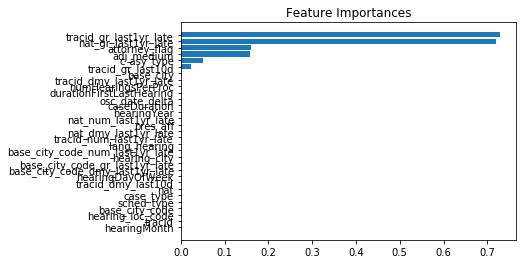

In [20]:
# PLOT FEATURE IMPORTANCE (summed absolute weights)

# simplify feature weights--sum together all weights for a given category (all nationalities)
num_features = num_pipeline.named_steps['selector'].get_feature_names()
cat_features = cat_pipeline_reg.named_steps['labeler'].get_feature_names()
cat_classes = cat_pipeline_reg.named_steps['labeler'].get_orig_classes()
attributes = np.append(num_features,pd.unique(cat_classes)) 
attributes_long = num_features + cat_classes #for each of >1000 feature, lists original feature name, i.e. nat or tracid
feature_weight_simple = np.zeros(len(attributes))
for i in range(len(attributes)):
    weights = feature_weight[[x == attributes[i] for x in attributes_long]]
    feature_weight_simple[i] = np.sum(weights)
    
indices = np.argsort(feature_weight_simple)
plt.title('Feature Importances')
plt.barh(range(len(indices)), feature_weight_simple[indices], align='center')
plt.yticks(range(len(indices)), [attributes[i] for i in indices])


## Evaluate on Test Set

In [ ]:
test = file[file.idncase.isin(test_cases.num)] #don't need this now
test_data = clean.transform(test)
y_test = test_data['dec']
X_test = test_data.drop(columns=['dec'], axis=1)
X_test_tr = full_pipeline.transform(X_test)

In [ ]:
#num_features = num_pipeline.named_steps['selector'].get_feature_names()
#cat_features = cat_pipeline.named_steps['labeler'].get_feature_names()

In [ ]:
print(final_model.score(X_test_tr, y_test))

## Hyperparameter Grid Search On Decision Tree

In [29]:
# DELETE THIS ENTIRE SECTION?!!?!?
X_train_tr = full_pipeline.fit_transform(X_train)

In [30]:
X_train_tr.shape

(438696, 26)

In [24]:
X_train_tr.head

AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [61]:
param_grid_dt = {"max_depth": [10, 5, 3, 1, None],
        "max_features": randint(1, min(20,X_train_tr.shape[1]-1)),
        "min_samples_leaf": randint(1, 20),
        "criterion": ["gini", "entropy"]}

In [62]:
dec_tree = DecisionTreeClassifier()
grid_search_dt = RandomizedSearchCV(dec_tree, param_grid_dt, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search_dt.fit(X_train_tr, y_train)
result = pd.DataFrame(grid_search_dt.cv_results_)
print(result)

   mean_fit_time  mean_score_time  mean_test_score  mean_train_score  \
0       0.953832         0.110080         0.655707          0.763854   
1       1.909836         0.136338         0.630299          0.752670   
2       1.818806         0.163459         0.651519          0.879750   
3       1.009844         0.094178         0.572087          0.607357   
4       1.712396         0.062882         0.673123          0.817665   
5       1.075524         0.067035         0.601877          0.711458   
6       0.933877         0.088933         0.603698          0.707013   
7       0.861367         0.136385         0.543261          0.607910   
8       1.334851         0.082000         0.667590          0.813420   
9       0.838890         0.059585         0.653073          0.771945   

  param_criterion param_max_depth param_max_features param_min_samples_leaf  \
0         entropy              10                  1                     13   
1            gini               5                

In [63]:
final_model_dt = grid_search_dt.best_estimator_
print(final_model_dt.score(X_test_tr, y_test))

NameError: name 'X_test_tr' is not defined

Text(0.5,0,'Relative Importance')

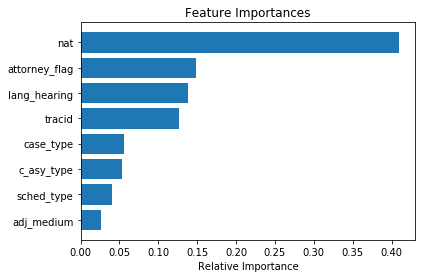

In [64]:
feature_weight_dt = grid_search_dt.best_estimator_.feature_importances_
num_features = num_pipeline.named_steps['selector'].get_feature_names()
cat_features = cat_pipeline.named_steps['selector'].get_feature_names()
attributes = num_features + cat_features
indices = np.argsort(feature_weight_dt)
ordered_attributes = [attributes[i] for i in indices]

plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), feature_weight_dt[indices], align='center')
plt.yticks(range(len(indices)), ordered_attributes)
plt.xlabel('Relative Importance')

## Hyperparameter Grid Search On Random forest

In [31]:
# HYPERPARAMETERS FOR RANDOM FOREST

param_grid_rf = {
    'n_estimators': [100, 300, 500],
    'max_features': [2, 4, 6, 8, 10],
    'bootstrap': [False, True],
    'max_depth':[2, 4, 6, 8]
}

In [ ]:
# FIT AND PRINT RESULTS OF RANDOM FOREST

rf = RandomForestClassifier()
grid_search_rf = RandomizedSearchCV(rf, param_grid_rf, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search_rf.fit(X_train_tr, y_train)
result = pd.DataFrame(grid_search_rf.cv_results_)
print(result)

In [17]:
# EVALUATE RANDOM FOREST ON TEST SET

final_model_rf = grid_search_rf.best_estimator_
print(final_model_rf.score(X_test_tr, y_test))

NameError: name 'X_test_tr' is not defined

Text(0.5,0,'Relative Importance')

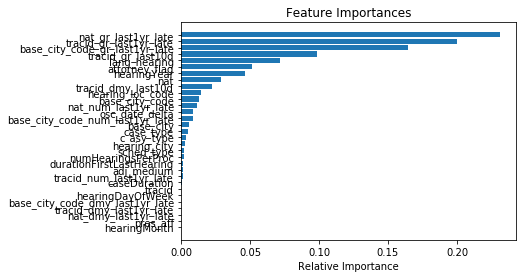

In [19]:
# PLOT FEATURE IMPORTANCE

feature_weight_rf = grid_search_rf.best_estimator_.feature_importances_
indices_rf = np.argsort(feature_weight_rf)
num_features = num_pipeline.named_steps['selector'].get_feature_names()
cat_features = cat_pipeline.named_steps['selector'].get_feature_names()
attributes = num_features + cat_features
ordered_attributes_rf = [attributes[i] for i in indices_rf]
plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices_rf)), feature_weight_rf[indices_rf], align='center')
plt.yticks(range(len(indices_rf)), ordered_attributes_rf)
plt.xlabel('Relative Importance')